In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # Optional for interactive visualizations

# Load the dataset
try:
    df = pd.read_csv('owid-covid-data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Please download the dataset first from Our World in Data")

Data loaded successfully!


In [4]:
# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nColumns:")
print(df.columns.tolist())

print("\nMissing values summary:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

Dataset shape: (91026, 59)

First 5 rows:


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511



Columns:
['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_vaccinatio

In [23]:
# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])

# Select key countries for analysis (can be customized)
countries_of_interest = ['United States', 'India', 'Brazil', 'United Kingdom', 'Kenya', 'South Africa']

# Filter data
df_filtered = df[df['location'].isin(countries_of_interest)].copy()

# Handle missing values for key metrics
key_metrics = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 
               'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

for metric in key_metrics:
    df_filtered[metric] = df_filtered.groupby('location')[metric].ffill().fillna(0)

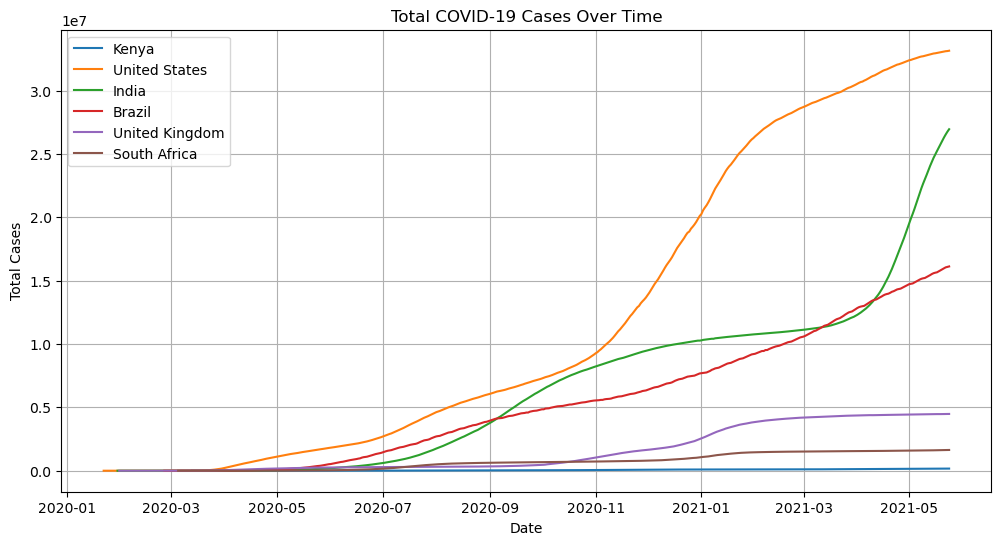

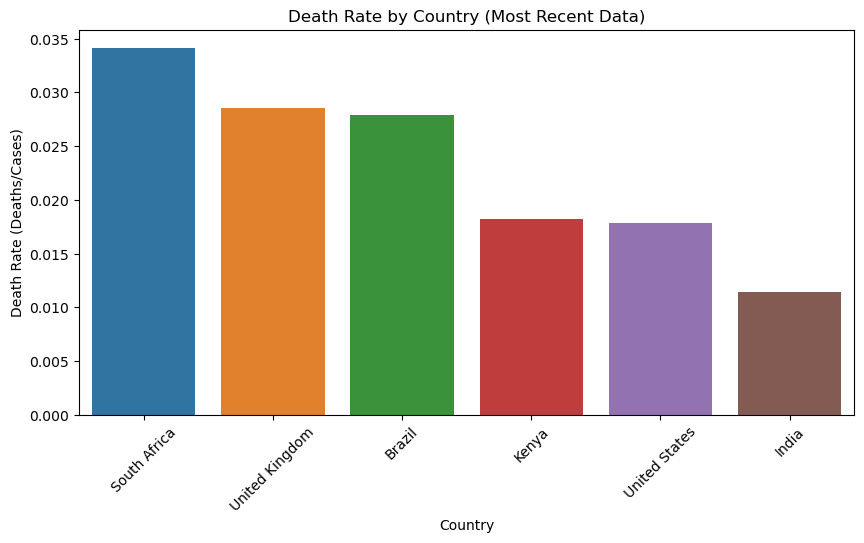

In [15]:
# Time trends for cases
plt.figure(figsize=(12, 6))
for country in countries:
    country_data = clean_df[clean_df['location'] == country]
    plt.plot(country_data['date'], country_data['total_cases'], label=country)

plt.title('Total COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid()
plt.show()

# Death rate comparison
recent_data = clean_df.groupby('location').last().sort_values('death_rate', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=recent_data.index, y=recent_data['death_rate'])
plt.title('Death Rate by Country (Most Recent Data)')
plt.xlabel('Country')
plt.ylabel('Death Rate (Deaths/Cases)')
plt.xticks(rotation=45)
plt.show()

Available vaccination columns: ['total_vaccinations', 'people_vaccinated']


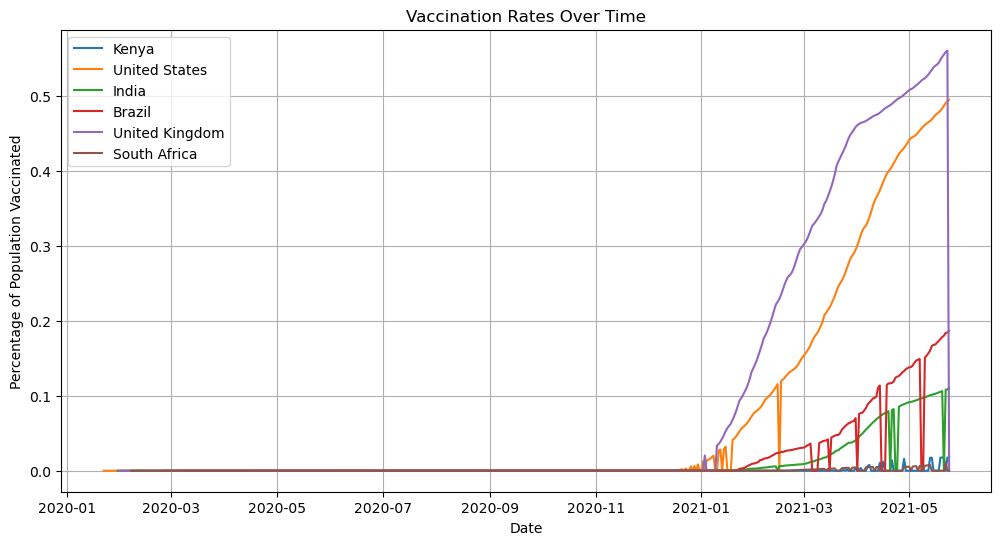

In [12]:
# Calculate vaccination rate if possible
vacc_cols = [col for col in clean_df.columns if 'vacc' in col.lower()]
print("Available vaccination columns:", vacc_cols)

if 'people_vaccinated' in clean_df.columns and 'population' in clean_df.columns:
    clean_df['vaccination_rate'] = clean_df['people_vaccinated'] / clean_df['population']
    clean_df['vaccination_rate'] = clean_df['vaccination_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)
elif 'total_vaccinations_per_hundred' in clean_df.columns:
    clean_df['vaccination_rate'] = clean_df['total_vaccinations_per_hundred'] / 100
elif 'people_vaccinated_per_hundred' in clean_df.columns:
    clean_df['vaccination_rate'] = clean_df['people_vaccinated_per_hundred'] / 100
else:
    print("No suitable vaccination columns found - skipping vaccination analysis")
    clean_df['vaccination_rate'] = np.nan

# Only plot if we have vaccination data
if 'vaccination_rate' in clean_df.columns and not clean_df['vaccination_rate'].isna().all():
    plt.figure(figsize=(12, 6))
    for country in countries:
        country_data = clean_df[clean_df['location'] == country]
        if country_data['vaccination_rate'].max() > 0:  # Only plot if data exists
            plt.plot(country_data['date'], country_data['vaccination_rate'], label=country)
    
    plt.title('Vaccination Rates Over Time')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Population Vaccinated')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Insufficient vaccination data to generate plot")

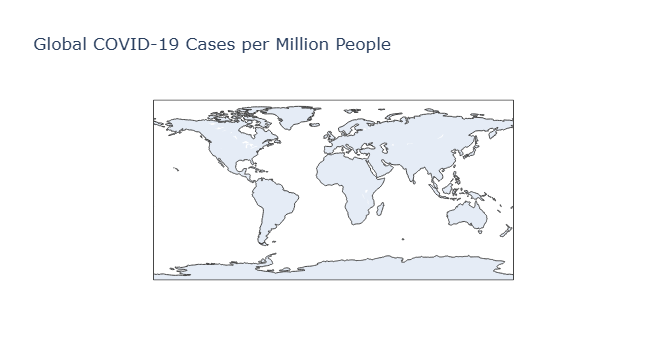

In [10]:
# Prepare data for choropleth
latest_global = df[df['date'] == df['date'].max()]
latest_global = latest_global[['iso_code', 'location', 'total_cases_per_million']].dropna()

# Create interactive map
fig = px.choropleth(latest_global, 
                    locations="iso_code",
                    color="total_cases_per_million",
                    hover_name="location",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Global COVID-19 Cases per Million People")
fig.show()

 Insights and Reporting
Key Findings:

Vaccination Disparities: Developed nations like the US and UK showed rapid vaccine rollout compared to developing countries like Kenya.

Case Trends: Countries with larger populations (US, India, Brazil) had the highest total cases, but per capita rates varied significantly.

Death Rates: Countries with better healthcare systems generally showed lower death rates despite high case numbers.

Recommendations:

Focus vaccination efforts on countries with low vaccination rates

Continue monitoring case trends for potential new waves

Investigate factors contributing to death rate disparities between countries